## Описание проекта

На основе исторических данных о заказах такси в аэропортах нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для прогноза.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48. Тестирование модели необходимо произвести на 10% последних наблюдений.

### Последовательность выполнения проекта

1. Загрузка данных и их визуальный осмотр.
2. Анализ данных и формирование признаков.
3. Обучение разных моделей с различными гиперпараметрами.
4. Проверка данных на тестовой выборке (10% от исходной).

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*'.

In [1035]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import xgboost as xgb

import time
import warnings
warnings.filterwarnings('ignore')

# 1. Визуальный осмотр данных

In [1036]:
df = pd.read_csv('D:\datasets\\taxi_orders.csv', index_col=[0], parse_dates=[0])
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


В таблице 26 000 объектов. Даные представлены за пол-года (с марта 2018 по август 2018) с шагом 10 минут.

In [1037]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим упорядоченность индексов.

In [1038]:
df.index.is_monotonic 

True

Посмотрим на график количества заказов

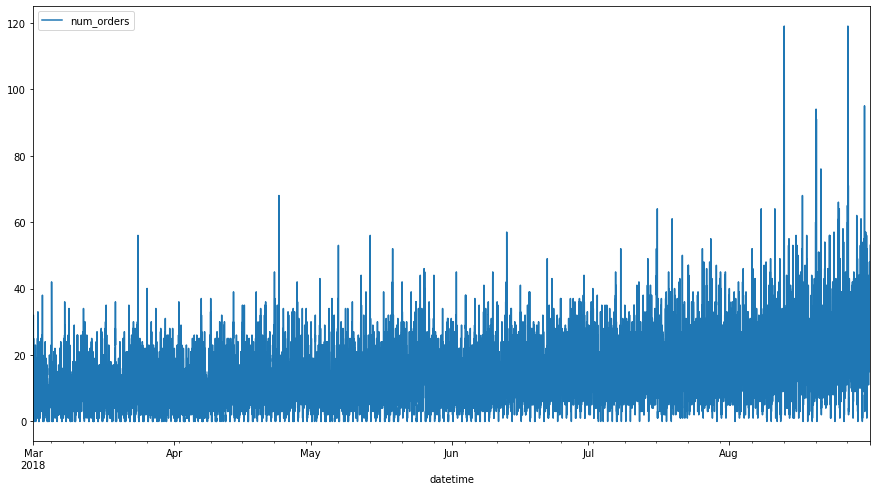

In [1039]:
df.plot(figsize=(15,8))

На графике практически не видно как меняется количество заказов.

Проведем ресэмплирование по одному часу.

In [1040]:
df = df.resample('1H').sum()

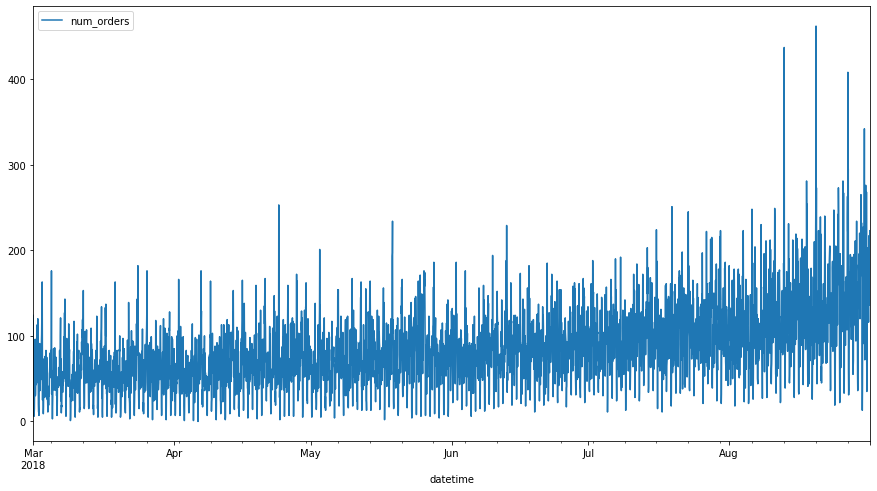

In [1041]:
df.plot(figsize=(15,8))

Добавим скользящее среднее за сутки.

In [1042]:
df['rolling_mean'] = df['num_orders'].rolling(24).mean()

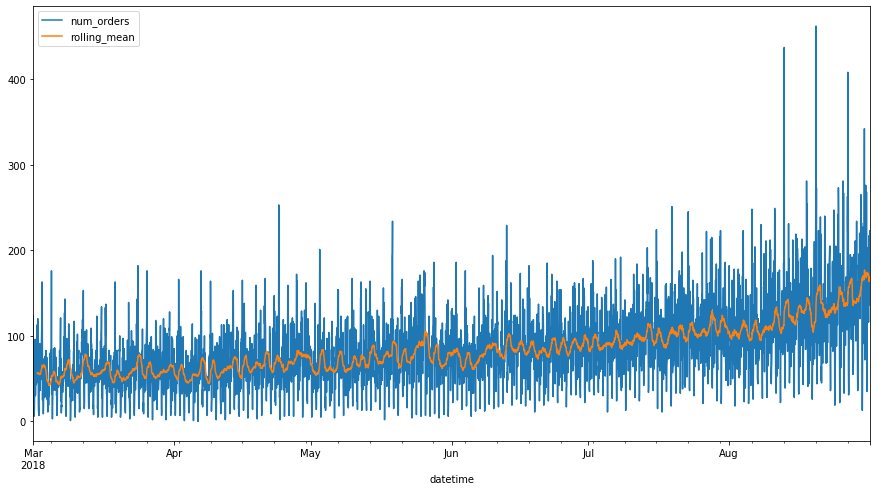

In [1043]:
df.plot(figsize=(15,8));

# 2. Формирование признаков

Разобьем наш ряд на составляющие.

In [1044]:
decomposed = seasonal_decompose(df['num_orders'])

In [1045]:
decomposed = seasonal_decompose(df['num_orders'])

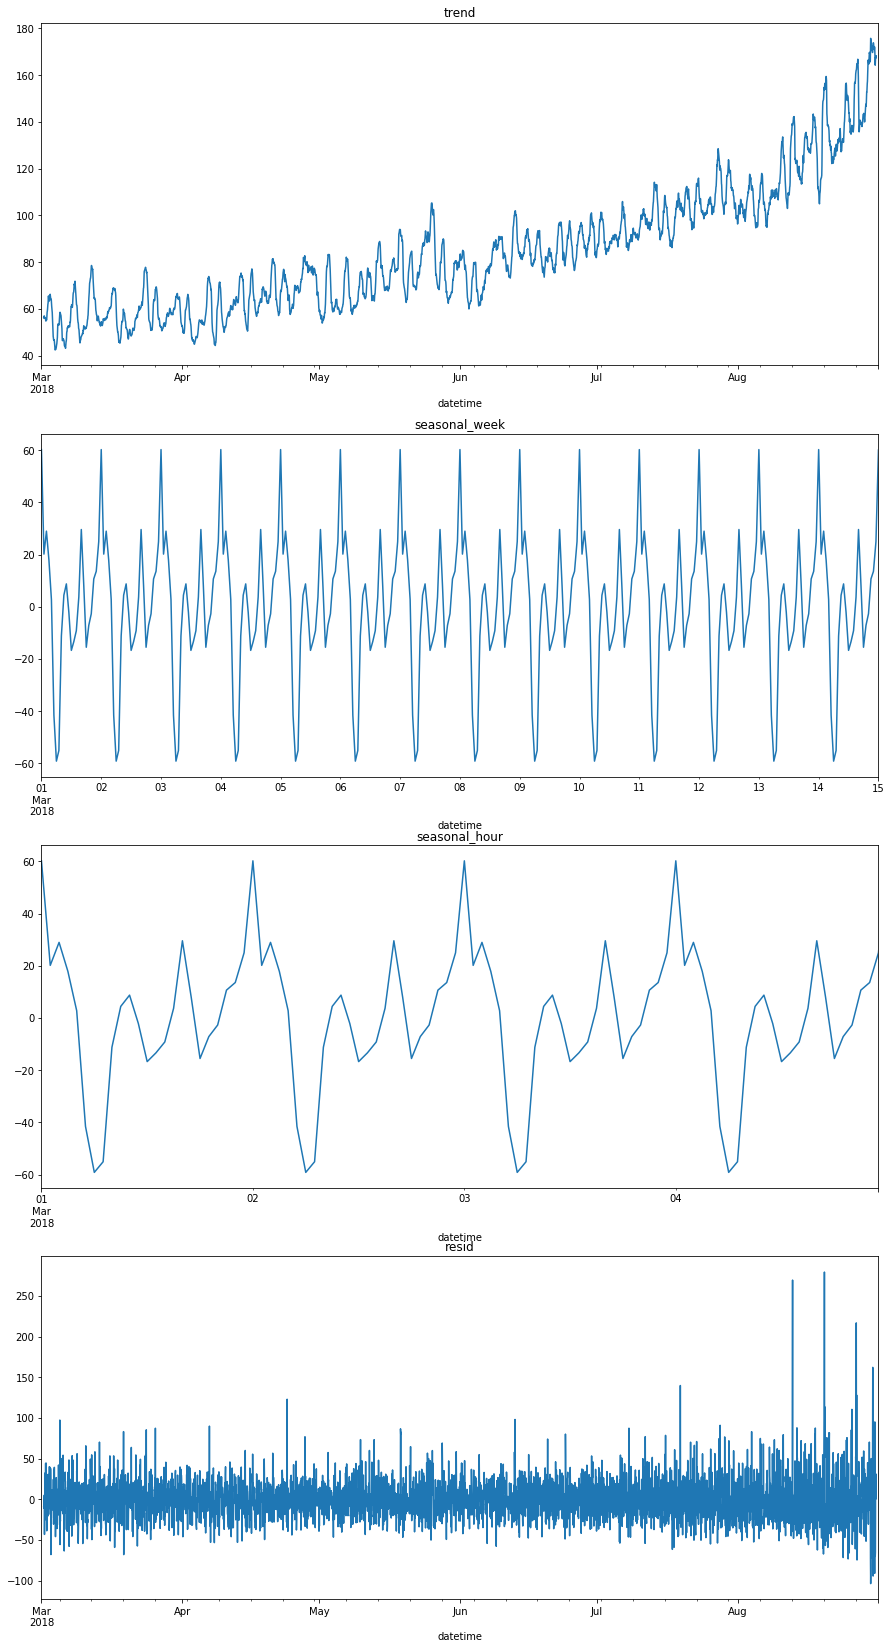

In [1046]:
plt.figure(figsize=(15,29))

plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('trend')

plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca(), xlim=('2018-03-01', '2018-03-15'))
plt.title('seasonal_week')
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca(), xlim=('2018-03-01 00:00', '2018-03-04 23:59'))
plt.title('seasonal_hour')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('resid');

1. С марта по август наблюдается тренд на рост заказов такси на 60%.
2. Наблюдаются суточные колебания с минимумом заказов около 6 утра и максимумом около полуночи. Колебания между днями недели отсутствуют.
3. В среднем шум состаляет +-25 заказов.
4. В конце датасета есть аномально высокие значения шумов. Скорее всего предсказать такие значения наша будущая модель не сможет. 

Создадим новые признаки из имеющихся. Наша задача предсказать количество заказов на следующий час. Поэтому, для создания новых признаков будем брать 2 - 3 из последних известных значений.

**Скользящее максимальных значений количества заказов.**

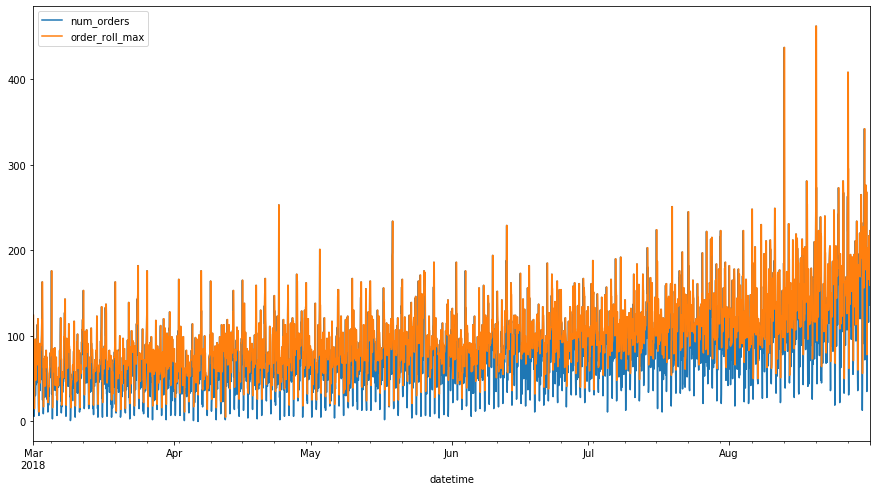

In [1047]:
df['order_roll_max'] = df['num_orders'].rolling(3).max()
df[['num_orders', 'order_roll_max']].plot(figsize=(15,8))

**Скользящее минимальное количество заказов**

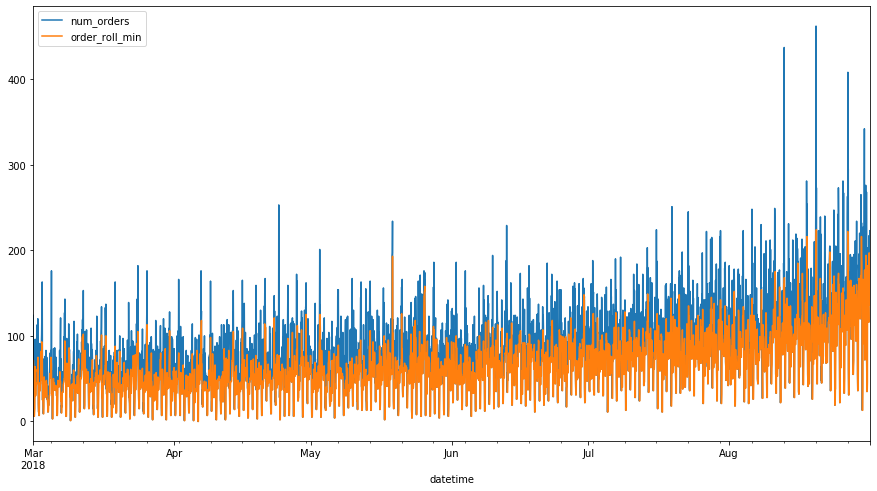

In [1048]:
df['order_roll_min'] = df['num_orders'].rolling(3).min()
df[['num_orders', 'order_roll_min']].plot(figsize=(15,8))

Выбранные признаки хорошо отражают локальные максимумы и минимумы.

**Скользящее среднее значение количества заказов**

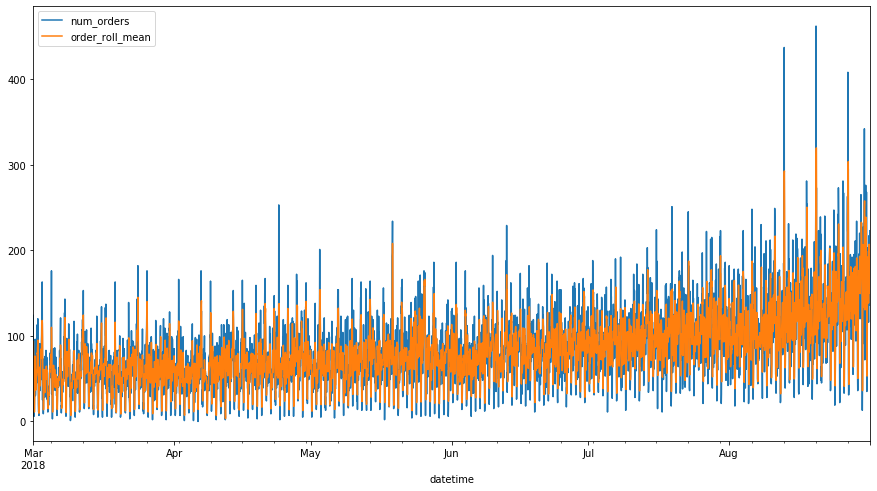

In [1049]:
df['order_roll_mean'] = df['num_orders'].rolling(3).mean()
df[['num_orders', 'order_roll_mean']].plot(figsize=(15,8))

**Скользящее среднее тренда**

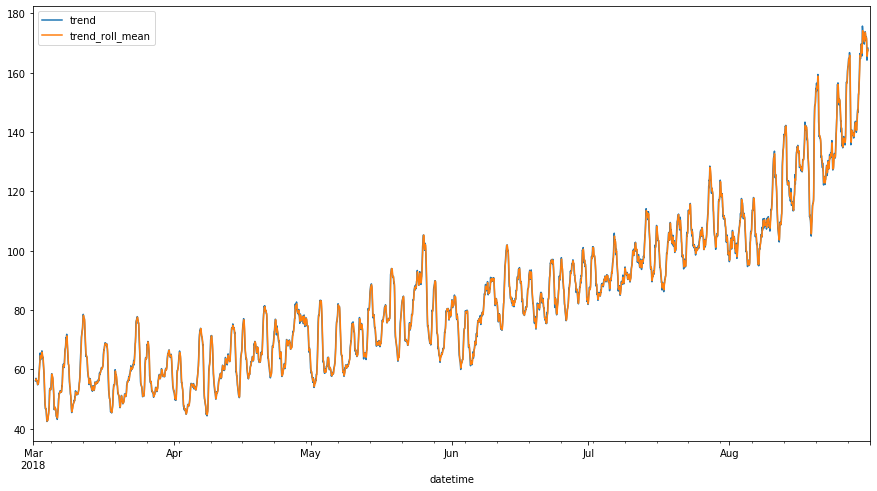

In [1050]:
df['trend'] = decomposed.trend
df['trend_roll_mean'] = df['trend'].rolling(3).mean()
df[['trend', 'trend_roll_mean']].plot(figsize=(15,8))

**Скользящее максимального значения тренда**

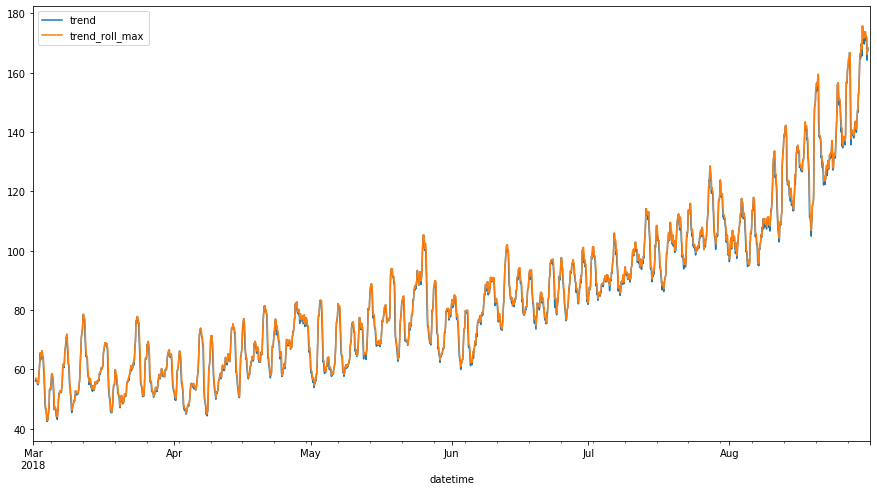

In [1051]:
df['trend_roll_max'] = df['trend'].rolling(3).max()
df[['trend', 'trend_roll_max']].plot(figsize=(15,8))

**Скользящее минимальное значения тренда**

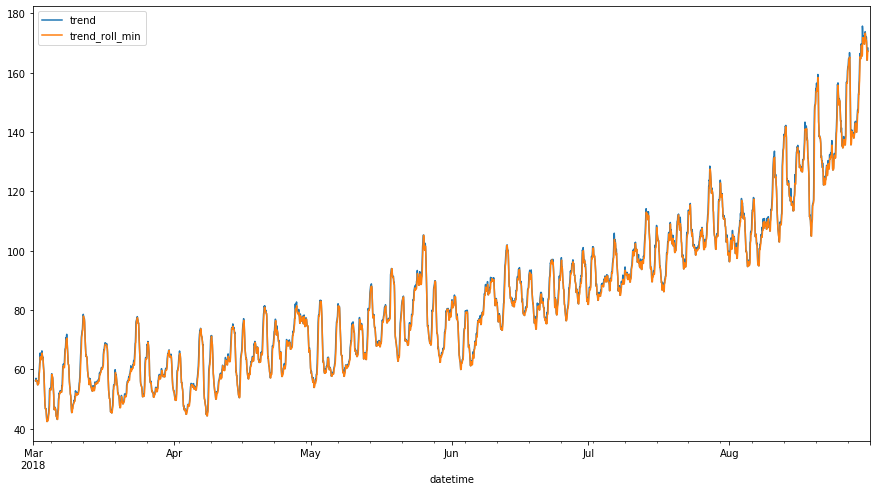

In [1052]:
df['trend_roll_min'] = df['trend'].rolling(3).min()
df[['trend', 'trend_roll_min']].plot(figsize=(15,8))

**Скользящее среднее сезонной составляющей ряда**

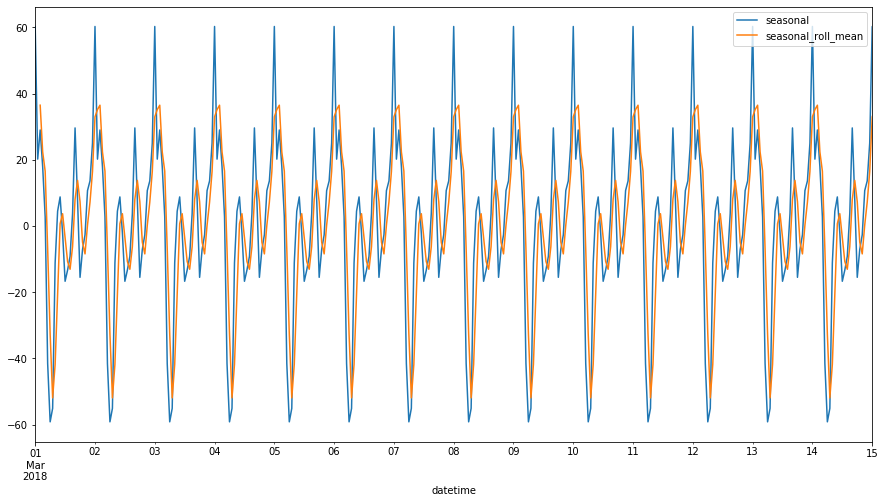

In [1053]:
df['seasonal'] = decomposed.seasonal
df['seasonal_roll_mean'] = df['seasonal'].rolling(3).mean()
df[['seasonal', 'seasonal_roll_mean']].plot(figsize=(15,8), xlim=('2018-03-01', '2018-03-15'))

Полученные значения плохо описывают экстремумы сезонной составляющей. Поэтому сделаем также скользящие максимальных и минимальных значений.

**Скользящее максимальное сезонной составляющей ряда**

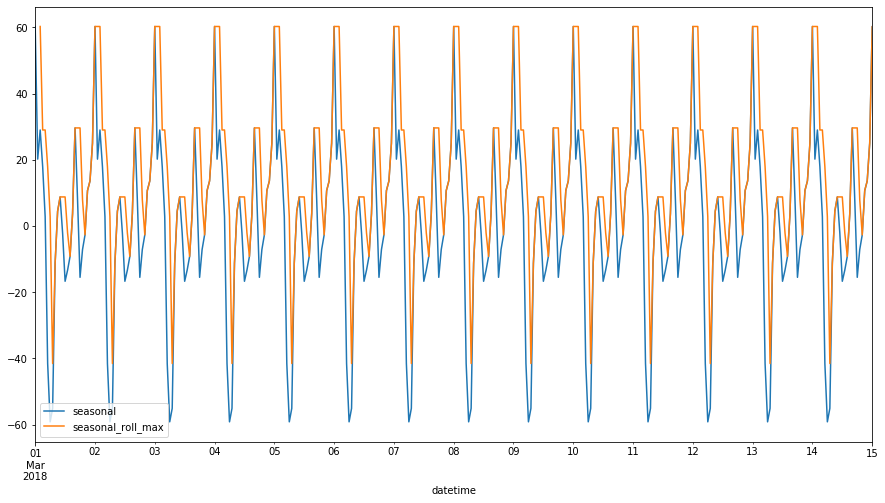

In [1054]:
df['seasonal_roll_max'] = df['seasonal'].rolling(3).max()
df[['seasonal', 'seasonal_roll_max']].plot(figsize=(15,8), xlim=('2018-03-01', '2018-03-15'))

**Скользящее минимальное сезонной составляющей ряда**

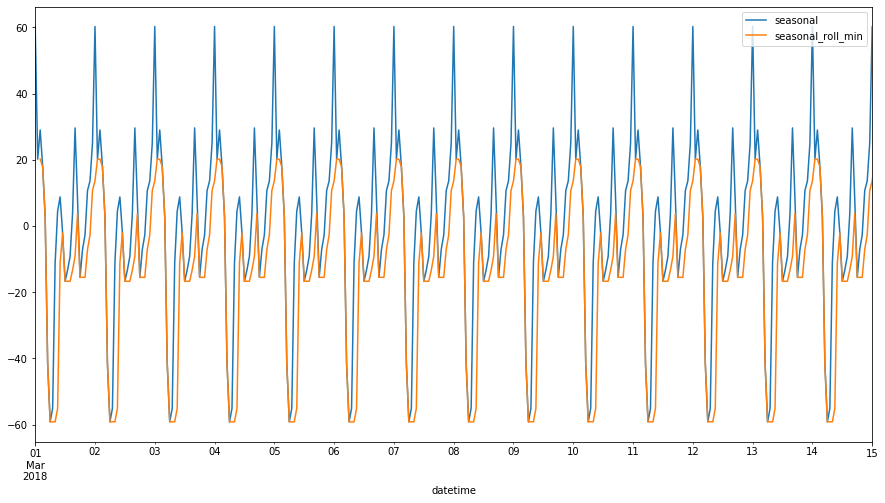

In [1055]:
df['seasonal_roll_min'] = df['seasonal'].rolling(3).min()
df[['seasonal', 'seasonal_roll_min']].plot(figsize=(15,8), xlim=('2018-03-01', '2018-03-15'))

Добавим к признакам месяц (для прогнозирования тренда), дни (для целостности признаков) и часы (для прогнозирования сезонности).

In [1056]:
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

И добавим прошлые значения количества заказов. Если нам нужно предсказать на один час вперед - значит мы можем брать второе последнее значение. В качестве признаков возьмем 4 предыдущих значения.

In [1057]:
num_shifts = 4
for i in range(num_shifts):
    df['order_shift_{}'.format(i+2)] = df['num_orders'].shift(i+2)

In [1058]:
df.head(3)

,num_orders,rolling_mean,order_roll_max,order_roll_min,order_roll_mean,trend,trend_roll_mean,trend_roll_max,trend_roll_min,seasonal,seasonal_roll_mean,seasonal_roll_max,seasonal_roll_min,month,day,hour,order_shift_2,order_shift_3,order_shift_4,order_shift_5
datetime,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.248112,NaN,NaN,NaN,3,1,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.177074,NaN,NaN,NaN,3,1,1,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,124.0,71.0,93.333333,NaN,NaN,NaN,NaN,28.982743,36.46931,60.248112,20.177074,3,1,2,124.0,NaN,NaN,NaN


Удалим получившиеся пропущенные значения.

In [1059]:
df = df.dropna()

Посмотрим на корреляцию полученных признаков

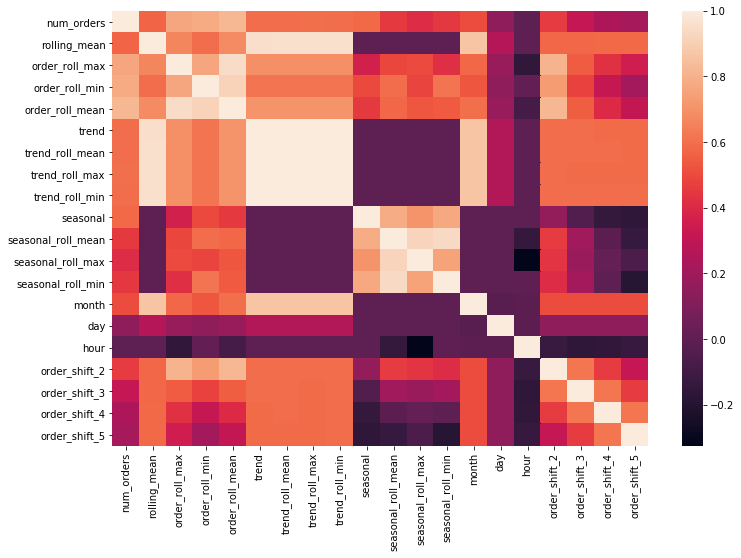

In [1060]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr())

Из тепловой карты видна сильная корреляция между отдельными признаками. Забегая вперед, следует отметить, что при попытке удалить часть из них, качество моделей падает. Поэтому, оставим их все и посмотрим как разные алгоритмы справятся с обучением.

Разделим выборку на тестовую и обучающую в соотношении 9:1:

In [1061]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [1062]:
print(train.shape)
print(test.shape)

(3942, 20)
(439, 20)


Подготовим таблицы обучающие и целевые признаки. Для подбора моделей будем использовать кросс-валидацию. Поскольку мы имеем дело с временными рядами, необходимо создать объект TimeSeriesSplit для корректного разбиения выборки.

In [1063]:
# формируем обучающие и целвые признаки
features_train = train.drop('num_orders', axis=1)
target_train = train[['num_orders']]

features_test = test.drop('num_orders', axis=1)
target_test = test[['num_orders']]

In [1064]:
# создаем объект кросс-валидации для временных рядов
tscv = TimeSeriesSplit()
tscv.split(features_train)

<generator object TimeSeriesSplit.split at 0x000001C221F1FEC8>

# 3. Обучение

Для подбора параметров напишем функцию для подбора гиперпараметров модели. Она принимает на вход необученную модель и словарь гиперпараметров, выводит на экран лучшие параметры, МАЕ и возвращает модель, обученную на полной выборке.

Для удобства добавим в функцию сохранение результата обучения в список result.

In [1065]:
result_df = pd.DataFrame(columns = ['name', 'rmse', 'fitting_time'])


def search_best_params(model, params):
    """
    Функция принимает на вход инициализированную необученную модель и словарь параметров для подбора
    подбирает параметры на кросс-валидации для временных рядов
    и возвращает обученную на лучших параметрах модель.
    
    Также функция сохраняет в список result результаты обучения: название модели, достигнутую метрику RMSE и время обучения.
    """
    model=model
    
    gridsv = GridSearchCV(param_grid=params,
                          estimator=model,
                          scoring='neg_mean_squared_error',
                          cv=tscv,
                          refit=True)
    
    # обучаем модель и считаем время обучения
    start_time = time.time()
    gridsv.fit(features_train, target_train)
    fitting_time = time.time() - start_time
    
    # сохраняем название модели и достигнутую метрику
    estimator_name = str(gridsv.estimator)[:str(gridsv.estimator).index('(')]
    estimator_rmse = abs(gridsv.best_score_) ** 0.5
    best_params = gridsv.best_params_
    
    # выводим результаты обучения
    print('Лучшие параметры: {}'.format(best_params))
    print('RMSE: {:.2f}'.format(estimator_rmse))
    print('time: {:.2f}'.format(fitting_time))
    
    # добавляем строку с результатами обучения в итоговую таблицу
    result_df.loc[result_df.shape[0], :] = [estimator_name, estimator_rmse, fitting_time]
    
    return gridsv

**Линейная регрессия**

В качестве линейной регрессии применим RidgeCV, поскольку она может нивелировать случайную корреляцию независимых признаков. 

In [1066]:
model_rcv = RidgeCV()

params_rcv = {'normalize' : [True, False]}

model_rcv = search_best_params(model_rcv, params_rcv)

Лучшие параметры: {'normalize': False}
RMSE: 16.13
time: 0.08


**Случайный лес:**

In [1067]:
model_rfr = RandomForestRegressor(random_state=12)

params_rfr = {'max_depth' : [15,20,25],
              'min_samples_split' : [2, 4, 6],
              'min_samples_leaf' : [1, 3, 5]}

model_rfr = search_best_params(model_rfr, params_rfr)

Лучшие параметры: {'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 2}
RMSE: 16.59
time: 171.68


**LightGBM**

In [1068]:
model_lgb = lgb.LGBMRegressor(random_state=12, n_jobs=-1)

params_lgb = {'max_depth' : [5, 7, 10, 15],
              'learning_rate' : [0.1, 0.01, 0.001],
              'min_data_in_leaf' : [2, 10, 50]}

model_lgb = search_best_params(model_lgb, params_lgb)

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'min_data_in_leaf': 10}
RMSE: 16.02
time: 28.42


**XG boost**

In [1069]:
model_xgb = xgb.XGBRegressor(random_state=12, verbosity=0, n_jobs=-1)

params_xgb = {'max_depth' : [5, 10, 15, 20],
              'learning_rate' : [0.1, 0.01, 0.001],
              'min_child_weight' : [1, 2, 5, 10, 15, 20]}

model_xgb = search_best_params(model_xgb, params_xgb)

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10}
RMSE: 16.59
time: 83.05


Для оценки построенных моделей посмотрим что покажут модели, предсказывающие медианное значение для всех показателей и модель, предсказывающее предыдущее значение целевого признака.

**Медианная модель**

In [1070]:
pred_median = np.ones(target_test.shape) * target_train.median().values
rmse_median = mean_squared_error(pred_median, target_test) ** 0.5
result_df.loc[result_df.shape[0], :] = ['median', rmse_median, None]

**Модель, предсказывающая предыдущее значение**

In [1071]:
pred_previos = target_test.shift()
pred_previos.iloc[0] = target_train.iloc[-1]
rmse_previos = mean_squared_error(pred_previos, target_test) ** 0.5
result_df.loc[result_df.shape[0], :] = ['previos', rmse_previos, None]

In [1079]:
result_df

,name,rmse,fitting_time
0,RidgeCV,16.132,0.0847406
1,RandomForestRegressor,16.589,171.683
2,LGBMRegressor,16.0167,28.4159
3,XGBRegressor,16.5858,83.0463
4,median,86.0551,None
5,previos,58.9272,None


RMSE обученных моделей близки друг к другу. Но лучший результат по совокупности качества и скорости обучения у алгоритма Ridge.

# 4. Тестирование

Определим RMSE на тестовой выборке для модели  Ridge. 

In [1080]:
rmse = mean_squared_error(model_rcv.predict(features_test), target_test) ** 0.5
print('RMSE = {:.2f}'.format(rmse))

RMSE = 25.76


Построим график сравнения целевого признака и наших предсказаний.

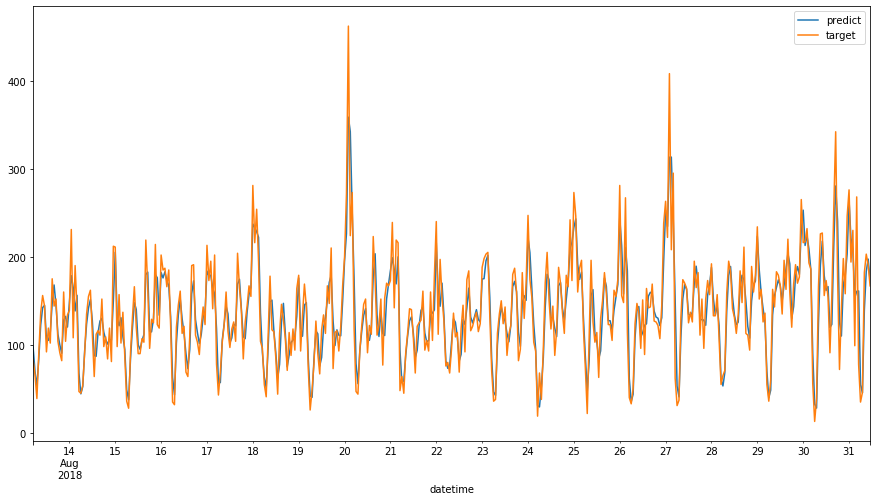

In [1081]:
result_test = pd.DataFrame(index=target_test.index, columns=['predict', 'target'])
result_test['predict'] = model_rcv.predict(features_test)
result_test['target'] = target_test
result_test.plot(figsize=(15,8));

Предсказания хорошо ложаться на ответы тестовой выборки за исключением трех максимальных пиков.

# Выводы:

1. Проведен анализ временного ряда. Выделены составляющие тренда, сезонности и шума.
2. На основе количества заказов на определнный час подготовлены признаки, отражающие предыдущие значения, максимальные и минимальные значения.
3. Обучено несколько моделей. Наилучший результат на кросс-валидации показала RidgeRegression c RMSE=16.1.
4. На тестовой выборке модель показала RMSE=25.76.